<h2 align="center">Data Science Fundamentals CSE 519</h2>
<h2 align="center">Prof. Steven Skiena</h2>
<h2 align="center">Homework 3</h2>
 
### Importing Libraries

In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn import model_selection, preprocessing, metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
import datetime
import lightgbm as lgb

### Reading the data into a dataframe by expanding the json columns

In [2]:
def data(csv_path):
    json_columns = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                 converters={column: json.loads for column in json_columns}, 
                 dtype={'fullVisitorId': 'str'})
    
    for column in json_columns:
        column_df = json_normalize(list(df[column]))
        column_df.columns = ["{}.{}".format(column, subcolumn) for subcolumn in column_df.columns]
        df = df.drop(column, axis=1).merge(column_df, right_index=True, left_index=True)
    return df

### Loading training and test data sets

In [3]:
train_df = data('D:/PycharmProjects/DSF Assignment 3/train.csv')

In [4]:
test_df = data('D:/PycharmProjects/DSF Assignment 3/test.csv')

In [5]:
print(train_df.shape)
print(test_df.shape)

(903653, 55)
(804684, 53)


In [6]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


In [7]:
train_df.dtypes

channelGrouping                                      object
date                                                  int64
fullVisitorId                                        object
sessionId                                            object
socialEngagementType                                 object
visitId                                               int64
visitNumber                                           int64
visitStartTime                                        int64
device.browser                                       object
device.browserSize                                   object
device.browserVersion                                object
device.deviceCategory                                object
device.flashVersion                                  object
device.isMobile                                        bool
device.language                                      object
device.mobileDeviceBranding                          object
device.mobileDeviceInfo                 

### Finding all columns having constant values

In [8]:
constant_columns = [c for c in train_df.columns if train_df[c].nunique(dropna=False)==1]
print(constant_columns, len(constant_columns))

['socialEngagementType', 'device.browserSize', 'device.browserVersion', 'device.flashVersion', 'device.language', 'device.mobileDeviceBranding', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.operatingSystemVersion', 'device.screenColors', 'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits', 'trafficSource.adwordsClickInfo.criteriaParameters'] 19


### Removing all constant columns and columns that are not present in test data

In [9]:
train_df.drop(constant_columns, axis=1, inplace=True)
train_df.drop(['trafficSource.campaignCode'], axis=1, inplace=True)

In [10]:
test_df.drop(constant_columns, axis=1, inplace=True)

### Remove all rows with duplicate sessionId

In [11]:
train_df.drop_duplicates(subset = 'sessionId', keep = 'first', inplace = True)

In [12]:
print(train_df.shape)
print(test_df.shape)

(902755, 35)
(804684, 34)


### Type casting desired features to float

In [13]:
num_cols = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime", 'totals.bounces',  'totals.newVisits']    
for col in num_cols:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)

In [14]:
train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].astype('float')

### Looking at the distribution of transaction revenue 

In [15]:
gtr = train_df.groupby('fullVisitorId')['totals.transactionRevenue'].sum().reset_index()
print(gtr['totals.transactionRevenue'].isnull().sum())

704185


In [16]:
gtr['totals.transactionRevenue'].count()

9982

In [17]:
print(gtr.shape)

(714167, 2)


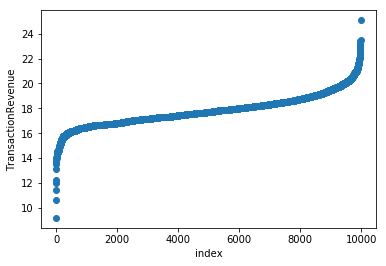

In [18]:
plt.figure()
plt.scatter(range(gtr.shape[0]), np.sort(np.log1p(gtr['totals.transactionRevenue'])))
plt.xlabel('index')
plt.ylabel('TransactionRevenue')
plt.show()

In [19]:
data_instances = (train_df['totals.transactionRevenue']>0).sum()
unique_customers = (gtr['totals.transactionRevenue']>0).sum()
print("Data Instances having more than zero revenue : ", data_instances, " and ratio is : ", data_instances / train_df.shape[0])
print("Unique Customers having more than zero revenue : ", unique_customers, "and the ratio is : ", unique_customers / gtr.shape[0])

Data Instances having more than zero revenue :  11499  and ratio is :  0.0127376752275
Unique Customers having more than zero revenue :  9982 and the ratio is :  0.0139771229978


In [20]:
print("Unique Customers in training set", train_df['fullVisitorId'].nunique(), "and total is", train_df.shape[0])
print("Unique Customers in test set", test_df['fullVisitorId'].nunique(), "and total is", test_df.shape[0])
print("Common visiters in train and test set", len(set(train_df['fullVisitorId'].unique()) & (set(test_df['fullVisitorId'].unique()))))

Unique Customers in training set 714167 and total is 902755
Unique Customers in test set 617242 and total is 804684
Common visiters in train and test set 7679


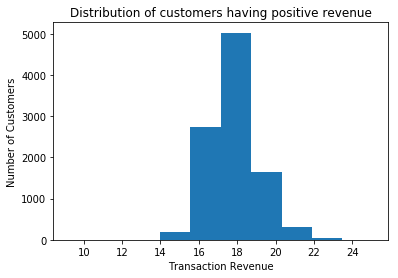

In [21]:
gtr1 = gtr.loc[gtr['totals.transactionRevenue'].isnull() == False]
plt.hist(np.log(gtr1.loc[gtr1['totals.transactionRevenue'] > 0, 'totals.transactionRevenue']));
plt.title("Distribution of customers having positive revenue")
plt.xlabel("Transaction Revenue")
plt.ylabel("Number of Customers")
plt.show()

### Observing train and test datasets for null values

In [22]:
train_df.isnull().sum()

channelGrouping                                      0
date                                                 0
fullVisitorId                                        0
sessionId                                            0
visitId                                              0
visitNumber                                          0
visitStartTime                                       0
device.browser                                       0
device.deviceCategory                                0
device.isMobile                                      0
device.operatingSystem                               0
geoNetwork.city                                      0
geoNetwork.continent                                 0
geoNetwork.country                                   0
geoNetwork.metro                                     0
geoNetwork.networkDomain                             0
geoNetwork.region                                    0
geoNetwork.subContinent                              0
totals.bou

In [23]:
test_df.isnull().sum()

channelGrouping                                      0
date                                                 0
fullVisitorId                                        0
sessionId                                            0
visitId                                              0
visitNumber                                          0
visitStartTime                                       0
device.browser                                       0
device.deviceCategory                                0
device.isMobile                                      0
device.operatingSystem                               0
geoNetwork.city                                      0
geoNetwork.continent                                 0
geoNetwork.country                                   0
geoNetwork.metro                                     0
geoNetwork.networkDomain                             0
geoNetwork.region                                    0
geoNetwork.subContinent                              0
totals.bou

### Transaction Revenue - Fill nan with 0, converting to log values and considering only buyers for analysing its relationship with various features 

In [24]:
train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].fillna(0)
train_df['totals.transactionRevenue'] = np.log1p(train_df['totals.transactionRevenue'])
train = train_df.loc[train_df['totals.transactionRevenue'] > 0.0]

### Heatmap for looking at correlation between features

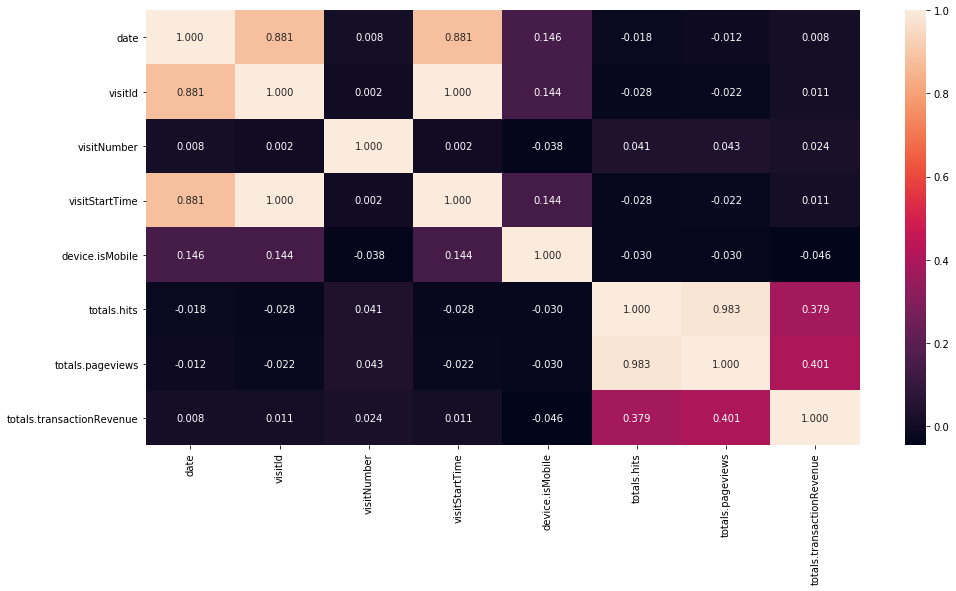

In [25]:
plt.figure(figsize=(16, 8))
sns.heatmap(train_df.drop(['totals.newVisits', 'totals.bounces'],axis=1).corr(),annot=True,fmt='0.3f')
plt.savefig('2_1.png', dpi=300, bbox_inches='tight')
plt.show()

### Looking at relationship between device and transaction revenue

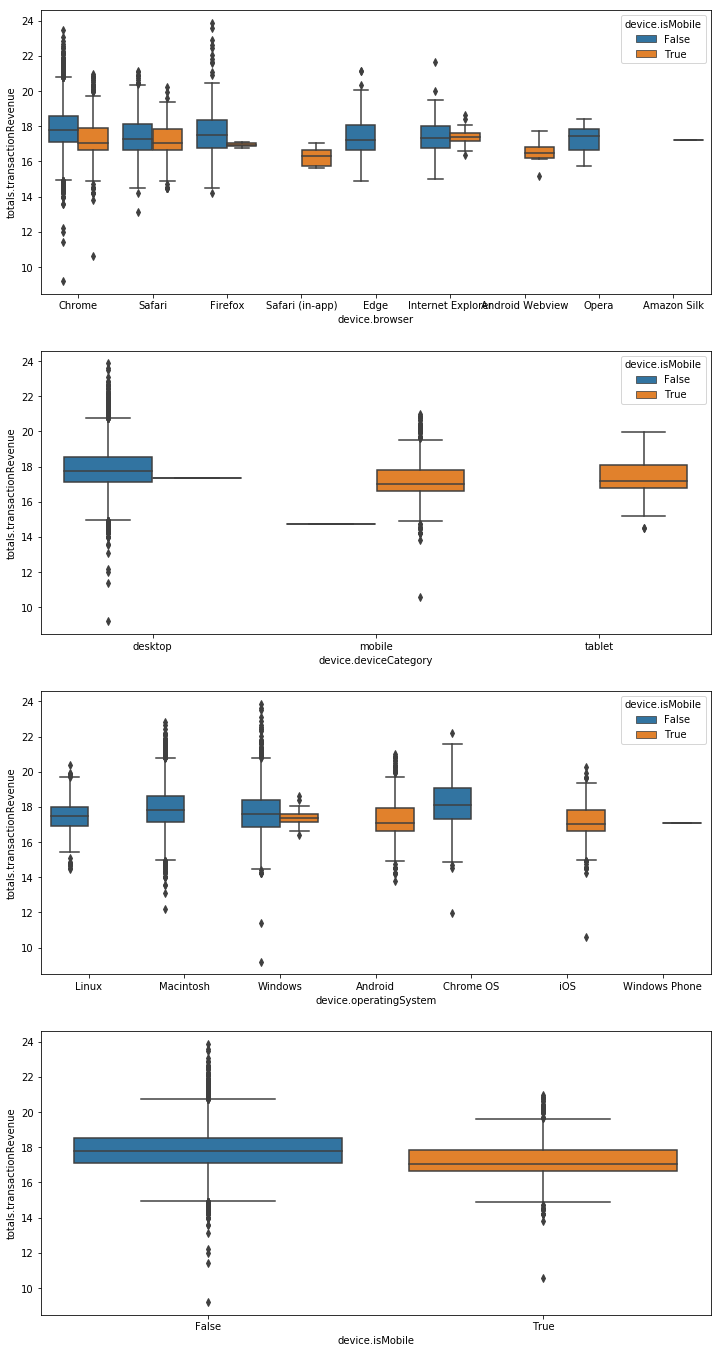

In [26]:
plt.figure()
fig, ax = plt.subplots(4, 1, figsize = (12, 24))
sns.boxplot(x="device.browser", y="totals.transactionRevenue", hue="device.isMobile", data=train, ax = ax[0]);
sns.boxplot(x="device.deviceCategory", y="totals.transactionRevenue", hue="device.isMobile", data=train, ax = ax[1]);
sns.boxplot(x="device.operatingSystem", y="totals.transactionRevenue", hue="device.isMobile", data=train, ax = ax[2]);
sns.boxplot(x="device.isMobile", y="totals.transactionRevenue", data=train, ax = ax[3])
plt.savefig('2_2_1.png', dpi=300, bbox_inches='tight')
plt.show()

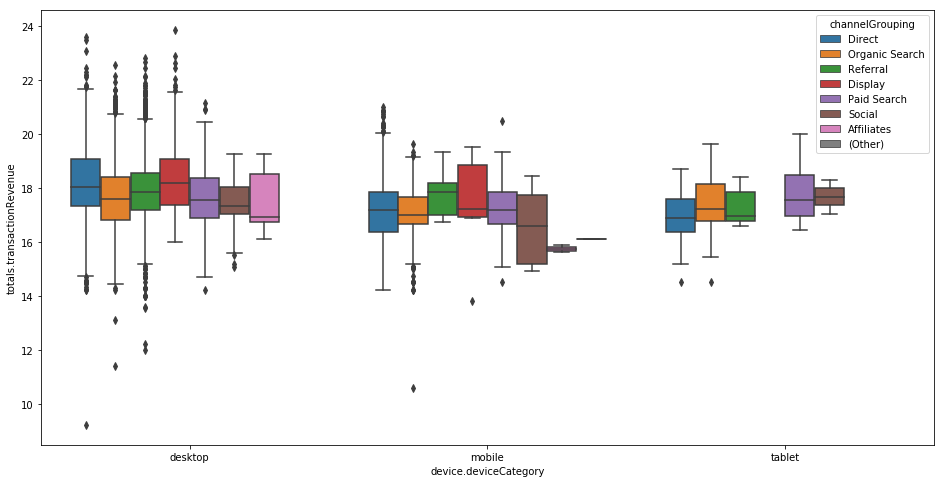

In [27]:
plt.figure(figsize=(16, 8))
sns.boxplot(x="device.deviceCategory", y="totals.transactionRevenue", hue="channelGrouping",  data=train)
plt.savefig('2_2_2.png', dpi=300, bbox_inches='tight')
plt.show()

### Looking at relationship between traffic and transaction revenue

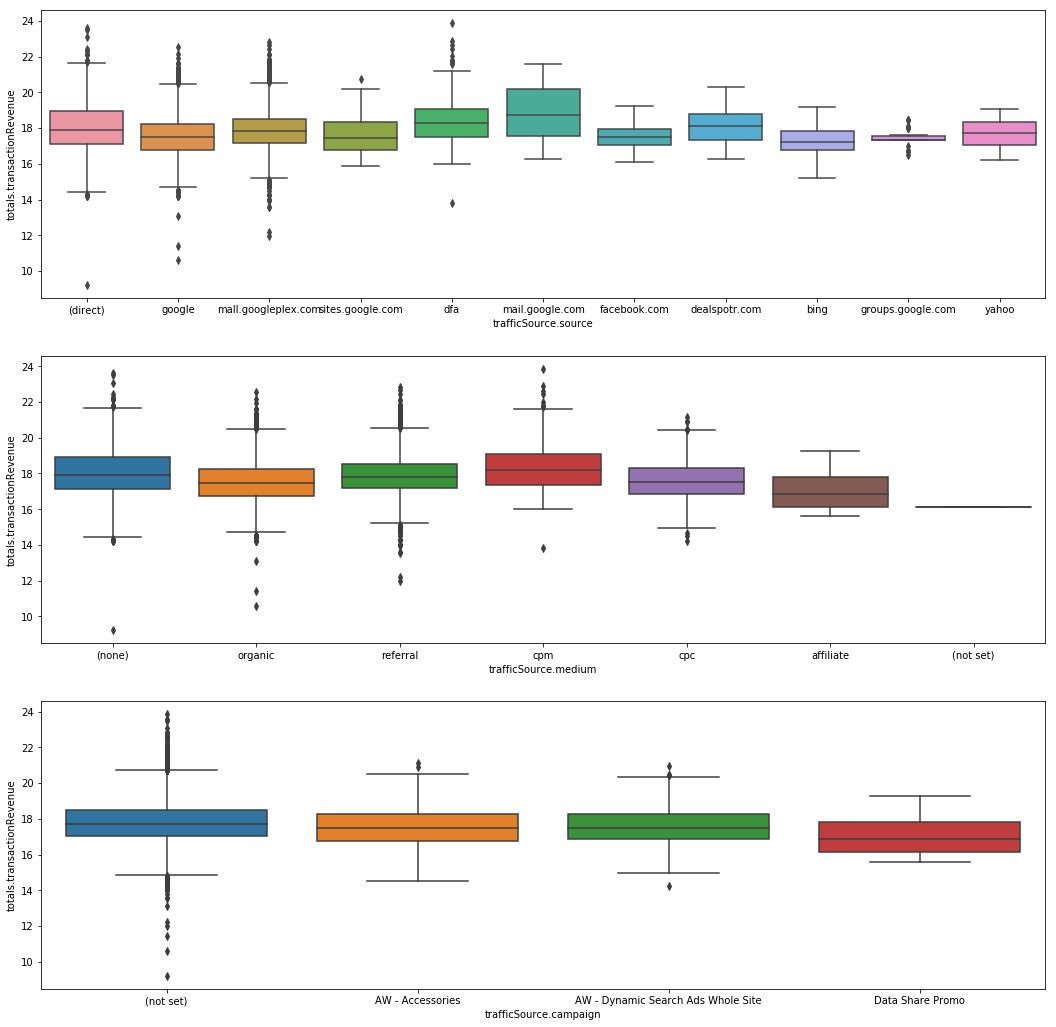

In [28]:
# Included only those traffic sources having more than 20 transaction revenue values 
# Included only those traffic campaigns having more than 1 transaction revenue values
#print(train.groupby('trafficSource.source')['totals.transactionRevenue'].count())
#print(train.groupby('trafficSource.campaign')['totals.transactionRevenue'].count())
source = ["(direct)", "bing", "dealspotr.com", "dfa", "facebook.com", "google", "groups.google.com", "mail.google.com", "mall.googleplex.com", "sites.google.com", "yahoo"]
campaign = ["(not set)", "AW - Accessories", "AW - Dynamic Search Ads Whole Site", "Data Share Promo"]
train_source = train.loc[train['trafficSource.source'].isin(source)]
train_campaign = train.loc[train['trafficSource.campaign'].isin(campaign)]
plt.figure()
fig, ax = plt.subplots(3, 1, figsize = (18, 18))
sns.boxplot(x="trafficSource.source", y="totals.transactionRevenue", data=train_source, ax = ax[0]);
sns.boxplot(x="trafficSource.medium", y="totals.transactionRevenue", data=train, ax = ax[1]);
sns.boxplot(x="trafficSource.campaign", y="totals.transactionRevenue", data=train_campaign, ax = ax[2]);
plt.savefig('2_3.png', dpi=300, bbox_inches='tight')
plt.show()

### Clustering transaction revenue based on geographic information

In [29]:
data_by_country_count = train["geoNetwork.country"].value_counts()
data = [dict(
    type = "choropleth",
    locations = data_by_country_count.index.values,
    locationmode = "country names",
    z = data_by_country_count.values,
    text = data_by_country_count.index.values,
    colorscale = "Viridis",
    autocolorscale = False,
    reversescale = True,
    marker = dict(line = dict(color = "rgb(180,180,180)", width = 0.5)),
    colorbar = dict(title="Count")
)]
layout = dict(title="Country vs No of purchases", height=600, width=800, geo=dict(showframe=False))
fig = dict(data=data, layout=layout)

In [31]:
plot(fig, validate=False)

'file://D:\\PycharmProjects\\DSF Assignment 3\\temp-plot.html'

In [32]:
print(train.groupby("geoNetwork.continent")["totals.transactionRevenue"].count())

geoNetwork.continent
(not set)        6
Africa           8
Americas     11269
Asia           124
Europe          78
Oceania         14
Name: totals.transactionRevenue, dtype: int64


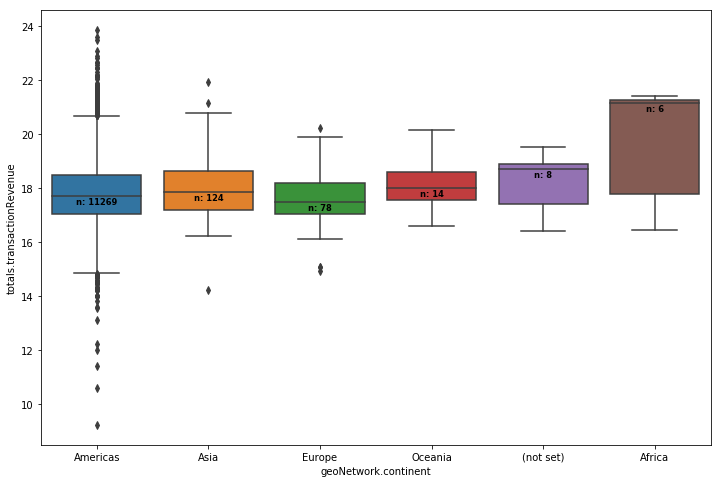

In [33]:
plt.figure(figsize = (12, 8))
ax = sns.boxplot(x="geoNetwork.continent", y="totals.transactionRevenue", data=train)
medians = train.groupby("geoNetwork.continent", sort=False)["totals.transactionRevenue"].median()
nobs = train["geoNetwork.continent"].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]

for i in range(len(nobs)):
    ax.text(i, medians[i] - 0.3, nobs[i], horizontalalignment='center', size='small', color='k', weight='semibold')
plt.savefig('3_1.png', dpi=300, bbox_inches='tight')
plt.show()

In [34]:
print(train.groupby("geoNetwork.subContinent")["totals.transactionRevenue"].count())

geoNetwork.subContinent
(not set)               6
Australasia            14
Caribbean              16
Central America        26
Central Asia            2
Eastern Africa          3
Eastern Asia           59
Eastern Europe         14
Northern Africa         1
Northern America    11130
Northern Europe        27
South America          97
Southeast Asia         32
Southern Africa         2
Southern Asia          11
Southern Europe         7
Western Africa          2
Western Asia           20
Western Europe         30
Name: totals.transactionRevenue, dtype: int64


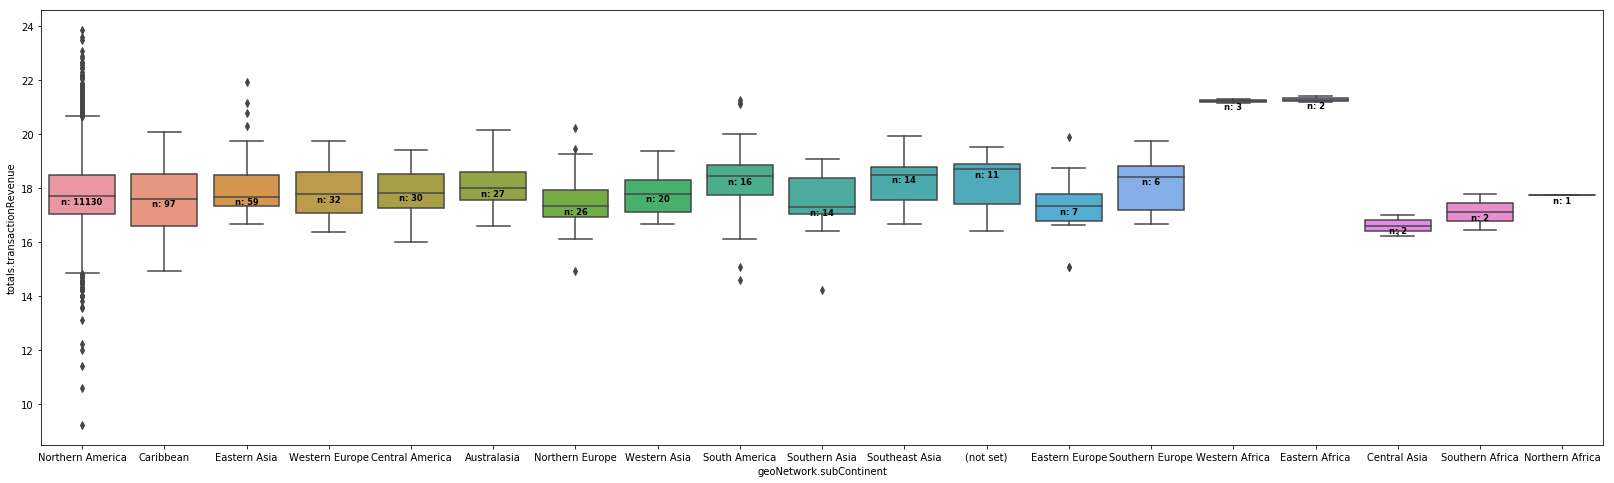

In [35]:
plt.figure(figsize = (28, 8))
ax = sns.boxplot(x="geoNetwork.subContinent", y="totals.transactionRevenue", data=train)
medians = train.groupby("geoNetwork.subContinent", sort=False)["totals.transactionRevenue"].median()
nobs = train["geoNetwork.subContinent"].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]

for i in range(len(nobs)):
    ax.text(i, medians[i] - 0.3, nobs[i], horizontalalignment='center', size='small', color='k', weight='semibold')
plt.savefig('3_2.png', dpi=300, bbox_inches='tight')
plt.show()

### GDP - per capita (Purchasing power parity) of all countries is included as a feature
### Reference - https://www.cia.gov/library/publications/the-world-factbook/rankorder/2004rank.html

In [36]:
data_ppp = pd.read_csv("D:/PycharmProjects/DSF Assignment 3/ppp_data.csv")

dict1 = {}
for i in range(len(data_ppp)):
    dict1[data_ppp.iloc[i]['Country']] = int(data_ppp.iloc[i]['PPP'])

print(train_df['geoNetwork.country'])
def PPP(country):
    if country in dict1:
        return dict1[country]
    return 0

train_df['PPP'] = train_df['geoNetwork.country'].apply(PPP)
test_df['PPP'] = test_df['geoNetwork.country'].apply(PPP)

0                 Turkey
1              Australia
2                  Spain
3              Indonesia
4         United Kingdom
5                  Italy
6               Pakistan
7              Australia
8                Austria
9            Netherlands
10                 India
11                France
12                Turkey
13              Pakistan
14                Brazil
15                 China
16           Netherlands
17                France
18             Singapore
19             Argentina
20                Poland
21               Germany
22                Canada
23              Thailand
24             Indonesia
25               Germany
26                France
27               Hungary
28                 India
29              Malaysia
               ...      
903623            Turkey
903624       Puerto Rico
903625     United States
903626     United States
903627            Canada
903628     United States
903629          Malaysia
903630             Chile
903631           Germany


In [37]:
print(train_df.dtypes)

channelGrouping                                  object
date                                              int64
fullVisitorId                                    object
sessionId                                        object
visitId                                           int64
visitNumber                                     float64
visitStartTime                                  float64
device.browser                                   object
device.deviceCategory                            object
device.isMobile                                    bool
device.operatingSystem                           object
geoNetwork.city                                  object
geoNetwork.continent                             object
geoNetwork.country                               object
geoNetwork.metro                                 object
geoNetwork.networkDomain                         object
geoNetwork.region                                object
geoNetwork.subContinent                         

### Top 10 users with probability of buying

In [38]:
train_ten = train_df
train_ten['Purchase'] = train_df['totals.transactionRevenue'].apply(lambda x: 1 if x > 0.0 else 0)
visitors = train_ten.groupby('fullVisitorId')['Purchase'].agg(['size', 'sum'])
visitors['probability'] = visitors['sum']/visitors['size']
test_top_users = visitors[visitors['sum'] > 5]
test_top_users = test_top_users.sort_values(by=['probability'], ascending=False)
print(test_top_users[:10])

                     size  sum  probability
fullVisitorId                              
0608915197735218105    17   13     0.764706
3857043812510146001     9    6     0.666667
4984366501121503466    24   16     0.666667
2411322974724385937    11    7     0.636364
8657427332734176422    10    6     0.600000
0777922178356486144    10    6     0.600000
7463172420271311409    16    9     0.562500
2446685875964479851    11    6     0.545455
2402527199731150932    31   15     0.483871
1814166460229302850    15    7     0.466667


### Converting all categorical variables to encodings between 0 and n_classes - 1

In [39]:
category_columns = ["channelGrouping", "device.browser", "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", "trafficSource.adwordsClickInfo.gclId",
            "trafficSource.adwordsClickInfo.isVideoAd", "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign", "trafficSource.isTrueDirect",
            "trafficSource.keyword", "trafficSource.medium", "trafficSource.referralPath", "trafficSource.source"]
for col in category_columns:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.isTrueDirect
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source


In [40]:
print(train_df.dtypes)

channelGrouping                                   int64
date                                              int64
fullVisitorId                                    object
sessionId                                        object
visitId                                           int64
visitNumber                                     float64
visitStartTime                                  float64
device.browser                                    int64
device.deviceCategory                             int64
device.isMobile                                    bool
device.operatingSystem                            int64
geoNetwork.city                                   int64
geoNetwork.continent                              int64
geoNetwork.country                                int64
geoNetwork.metro                                  int64
geoNetwork.networkDomain                          int64
geoNetwork.region                                 int64
geoNetwork.subContinent                         

In [41]:
print(train_df.head())

   channelGrouping      date        fullVisitorId  \
0                4  20160902  1131660440785968503   
1                4  20160902   377306020877927890   
2                4  20160902  3895546263509774583   
3                4  20160902  4763447161404445595   
4                4  20160902    27294437909732085   

                        sessionId     visitId  visitNumber  visitStartTime  \
0  1131660440785968503_1472830385  1472830385          1.0    1.472830e+09   
1   377306020877927890_1472880147  1472880147          1.0    1.472880e+09   
2  3895546263509774583_1472865386  1472865386          1.0    1.472865e+09   
3  4763447161404445595_1472881213  1472881213          1.0    1.472881e+09   
4    27294437909732085_1472822600  1472822600          2.0    1.472823e+09   

   device.browser  device.deviceCategory  device.isMobile    ...     \
0              35                      0            False    ...      
1              43                      0            False    ...      

### Light GBM Model

In [42]:
ppp = ['PPP']
X = train_df[category_columns + num_cols + ppp]
Y = train_df['totals.transactionRevenue']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
model = lgb.LGBMRegressor(objective='regression', njobs=7, n_estimators=100, learning_rate=0.09, sub_sample=0.75, max_depth=6)
model.fit(X_train, Y_train)
predictions = model.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(predictions, Y_test))
print(rmse)

1.60835542119


### Importance of each feature

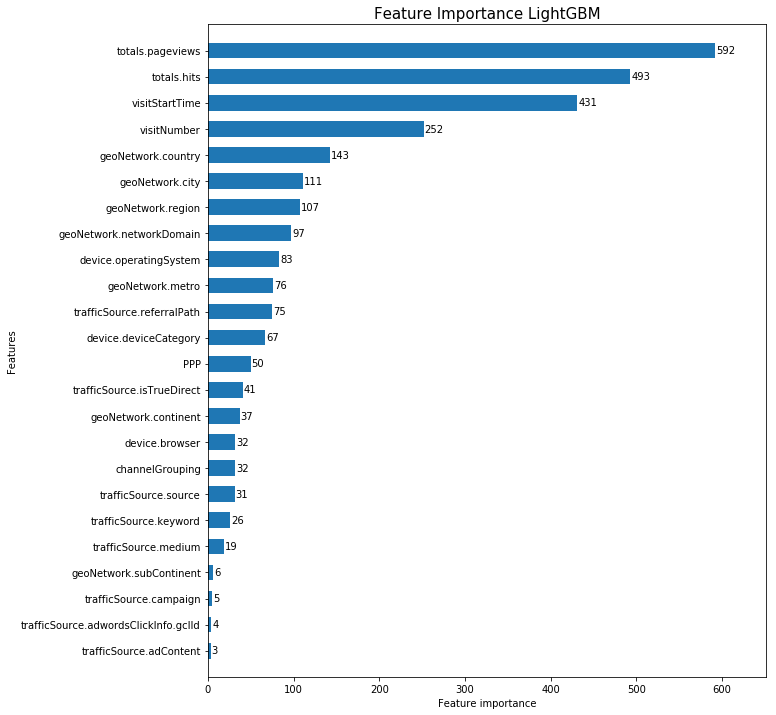

In [43]:
fig, ax = plt.subplots(figsize=(10,12))
lgb.plot_importance(model, max_num_features=50, height=0.6, ax=ax)
ax.grid(False)
plt.title("Feature Importance LightGBM", fontsize=15)
plt.show()

### Permutation Test

In [44]:
train_temp = train_df
cols = ["totals.pageviews", "totals.hits", "visitStartTime", "trafficSource.adContent", "trafficSource.campaign", "geoNetwork.subContinent"]
rmse_all = []
for col in cols:
    rmse_1 = []
    for i in range(20):
        train_temp[col] = np.random.permutation(train_temp[col])
        X_temp = train_temp[category_columns + num_cols]
        Y_temp = train_temp['totals.transactionRevenue']
        X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(X_temp, Y_temp, test_size=0.2)
        model_temp = lgb.LGBMRegressor(objective='regression', njobs=7, n_estimators=100, learning_rate=0.09, sub_sample=0.75, max_depth=6)
        model_temp.fit(X_train_1, Y_train_1)
        predictions_1 = model_temp.predict(X_test_1)
        rmse_1.append(np.sqrt(metrics.mean_squared_error(predictions_1, Y_test_1)))
    rmse_all.append(rmse_1)

In [45]:
for i in range(len(rmse_all)):
    count = 0
    for j in range(20):
        if rmse_all[i][j] < rmse:
            count = count + 1
    p_val = count/20
    print("Feature:", cols[i])
    print("p-value:", p_val)

Feature: totals.pageviews
p-value: 0.0
Feature: totals.hits
p-value: 0.0
Feature: visitStartTime
p-value: 0.0
Feature: totals.newVisits
p-value: 0.0
Feature: trafficSource.campaign
p-value: 0.0
Feature: geoNetwork.subContinent
p-value: 0.0


### LGBM test predictions

In [46]:
X_test = test_df[category_columns + num_cols + ppp]
test_predictions = model.predict(X_test)

In [47]:
sub_df = pd.DataFrame({"fullVisitorId" : test_df["fullVisitorId"].values})
test_predictions[test_predictions < 0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(test_predictions)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("lgb5.csv", index=False)